In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import optuna
import lightgbm as lgb
import xgboost as xgb
import warnings

warnings.filterwarnings("ignore")

# Load dataset
# Change to Mac path directory
file_path_new = r'C:\Users\Hubert N\Downloads\AMPICILLIN_E.COLI_12.4.24.csv'
df_new = pd.read_csv(file_path_new)

# Define target and features
columns_of_interest_new = [
    "Sex (0 = female; 1 = male)", "Neuter status (0 = castrated; 1 = not castrated)",
    "Age", "Weight (kg)", "Number of vet visits", "Hospitalization (no = 0; yes = 1)",
    "Duration of hospitalization (days)", "Antimicrobial therapy (no = 0; yes = 1)",
    "Duration of therapy (days)", "Color (0 = yellow/dark yellow/amber; 1 = straw; 2 = red/pink; 3 = brown/light & dark brown; 4 = other)",
    "Clarity (0 = clear; 1 = opaque/cloudy; 2 = SLhazy; 3 = hazy)", "USG", "PH", "Protein",
    "Glucose", "Ketones", "Creatinine", "Bilirubin...19", "Hemoprotein", "Sediment Vol",
    "Volume", "Lipid Layer", "WBC (simplified)", "Pyuria (1 if >/=4)", "RBC (simplified)",
    "Crystals (0 = none 1 = rare; 2 = few; 3 = mod; 4 = many)", "Casts-Hyaline",
    "Casts-Granular", "Bacteria quantity", "Bac Type", "Lipid Droplets", "Sperm"
]

df_new = df_new[df_new["Ampicillin_RSI"].isin(["R", "S"])]
df_new['Ampicillin_RSI'] = df_new['Ampicillin_RSI'].map({'S': 0, 'R': 1})
target_new = df_new['Ampicillin_RSI']
features_new = df_new[columns_of_interest_new]

# Count and percentage of R vs. S cases
r_count = df_new['Ampicillin_RSI'].sum()  # Count of R cases
s_count = len(df_new) - r_count  # Count of S cases
print(f"Count of 'R' cases: {r_count}")
print(f"Count of 'S' cases: {s_count}")
print(f"Percentage of 'R' cases: {r_count / len(df_new) * 100:.2f}%")
print(f"Percentage of 'S' cases: {s_count / len(df_new) * 100:.2f}%")

# Separate categorical and numerical columns
categorical_cols_new = [
    "Sex (0 = female; 1 = male)", "Neuter status (0 = castrated; 1 = not castrated)",
    "Hospitalization (no = 0; yes = 1)", "Antimicrobial therapy (no = 0; yes = 1)",
    "Color (0 = yellow/dark yellow/amber; 1 = straw; 2 = red/pink; 3 = brown/light & dark brown; 4 = other)",
    "Clarity (0 = clear; 1 = opaque/cloudy; 2 = SLhazy; 3 = hazy)", "Pyuria (1 if >/=4)",
    "Crystals (0 = none 1 = rare; 2 = few; 3 = mod; 4 = many)", "Casts-Hyaline",
    "Casts-Granular", "Bacteria quantity", "Bac Type", "Lipid Droplets", "Sperm"
]
categorical_cols_new = [col for col in categorical_cols_new if col in features_new.columns]
numerical_cols_new = [col for col in features_new.columns if col not in categorical_cols_new]

# Impute missing values
for col in numerical_cols_new:
    features_new[col] = pd.to_numeric(features_new[col], errors='coerce')
imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')
features_new[numerical_cols_new] = imputer_num.fit_transform(features_new[numerical_cols_new])
features_new[categorical_cols_new] = imputer_cat.fit_transform(features_new[categorical_cols_new])

# Scale numerical features and encode categorical features
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
features_new[numerical_cols_new] = scaler.fit_transform(features_new[numerical_cols_new])
encoded_cat_new = pd.DataFrame(encoder.fit_transform(features_new[categorical_cols_new]), index=features_new.index)
encoded_cat_new.columns = encoder.get_feature_names_out(categorical_cols_new)
features_preprocessed_new = pd.concat([features_new[numerical_cols_new], encoded_cat_new], axis=1)

# Feature selection
rf = RandomForestClassifier(random_state=42)
rf.fit(features_preprocessed_new, target_new)
selector = SelectFromModel(rf, threshold='median', prefit=True)
features_selected_new = selector.transform(features_preprocessed_new)
selected_feature_names = features_preprocessed_new.columns[selector.get_support()]
features_final_new = pd.DataFrame(features_selected_new, columns=selected_feature_names, index=features_preprocessed_new.index)

# Handle class imbalance
oversampling_methods = {'SMOTE': SMOTE(random_state=42), 'ADASYN': ADASYN(random_state=42), 'SMOTEENN': SMOTEENN(random_state=42)}
best_auc = 0
X_resampled_final, y_resampled_final = None, None
for name, sampler in oversampling_methods.items():
    X_resampled, y_resampled = sampler.fit_resample(features_final_new, target_new)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    if auc > best_auc:
        best_auc, X_resampled_final, y_resampled_final = auc, X_resampled, y_resampled

# Percentage of data used for training vs. testing
train_size = len(X_train)
test_size = len(X_test)
total_size = train_size + test_size
print(f"Training set size: {train_size} cases ({train_size / total_size * 100:.2f}%)")
print(f"Testing set size: {test_size} cases ({test_size / total_size * 100:.2f}%)")

# Train and evaluate models
models = {
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1),  # Suppress warnings
    'XGBoost': xgb.XGBClassifier(eval_metric='auc', use_label_encoder=False, random_state=42),
    'CatBoost': CatBoostClassifier(silent=True, eval_metric='AUC', random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42)
}

model_aucs = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    model_aucs[name] = auc
    print(f"{name} AUC: {auc:.4f}")

# Optuna hyperparameter tuning for LightGBM
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'verbose': -1  # Suppress warnings
    }
    model = lgb.LGBMClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    return roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Train the optimized LightGBM model
best_lgbm = lgb.LGBMClassifier(**study.best_params, random_state=42, verbose=-1)  # Suppress warnings
best_lgbm.fit(X_train, y_train)
auc_lgbm = roc_auc_score(y_test, best_lgbm.predict_proba(X_test)[:, 1])
print(f"Optimized LightGBM AUC: {auc_lgbm:.4f}")


Count of 'R' cases: 124
Count of 'S' cases: 403
Percentage of 'R' cases: 23.53%
Percentage of 'S' cases: 76.47%
Training set size: 367 cases (79.96%)
Testing set size: 92 cases (20.04%)
LightGBM AUC: 0.9367
XGBoost AUC: 0.9254


[I 2025-01-09 23:32:29,239] A new study created in memory with name: no-name-30b2f9b6-af7a-45af-aa63-5eb085aa0e9c
[I 2025-01-09 23:32:29,310] Trial 0 finished with value: 0.9194029850746268 and parameters: {'max_depth': 5, 'num_leaves': 28, 'learning_rate': 0.006307653387287768, 'n_estimators': 411}. Best is trial 0 with value: 0.9194029850746268.
[I 2025-01-09 23:32:29,380] Trial 1 finished with value: 0.9164179104477611 and parameters: {'max_depth': 9, 'num_leaves': 98, 'learning_rate': 0.010409851542942388, 'n_estimators': 334}. Best is trial 0 with value: 0.9194029850746268.
[I 2025-01-09 23:32:29,439] Trial 2 finished with value: 0.9283582089552238 and parameters: {'max_depth': 8, 'num_leaves': 79, 'learning_rate': 0.02751658009307021, 'n_estimators': 280}. Best is trial 2 with value: 0.9283582089552238.


CatBoost AUC: 0.9493
LogisticRegression AUC: 0.8167


[I 2025-01-09 23:32:29,480] Trial 3 finished with value: 0.9205970149253732 and parameters: {'max_depth': 6, 'num_leaves': 42, 'learning_rate': 0.04909477296335645, 'n_estimators': 169}. Best is trial 2 with value: 0.9283582089552238.
[I 2025-01-09 23:32:29,534] Trial 4 finished with value: 0.9176119402985075 and parameters: {'max_depth': 5, 'num_leaves': 69, 'learning_rate': 0.008481283553340675, 'n_estimators': 286}. Best is trial 2 with value: 0.9283582089552238.
[I 2025-01-09 23:32:29,616] Trial 5 finished with value: 0.9170149253731343 and parameters: {'max_depth': 8, 'num_leaves': 54, 'learning_rate': 0.011783670820435596, 'n_estimators': 430}. Best is trial 2 with value: 0.9283582089552238.
[I 2025-01-09 23:32:29,646] Trial 6 finished with value: 0.9020895522388059 and parameters: {'max_depth': 9, 'num_leaves': 32, 'learning_rate': 0.015133085472077463, 'n_estimators': 107}. Best is trial 2 with value: 0.9283582089552238.
[I 2025-01-09 23:32:29,723] Trial 7 finished with value: 

Optimized LightGBM AUC: 0.9373


Training LightGBM...

LightGBM Performance:
Sensitivity: 0.9403, Specificity: 0.6800
Accuracy: 0.8696 (95% CI: [0.8007, 0.9384])

Contingency Table:
                   Positive (Predicted)  Negative (Predicted)
Positive (Actual)                    63                     4
Negative (Actual)                     8                    17


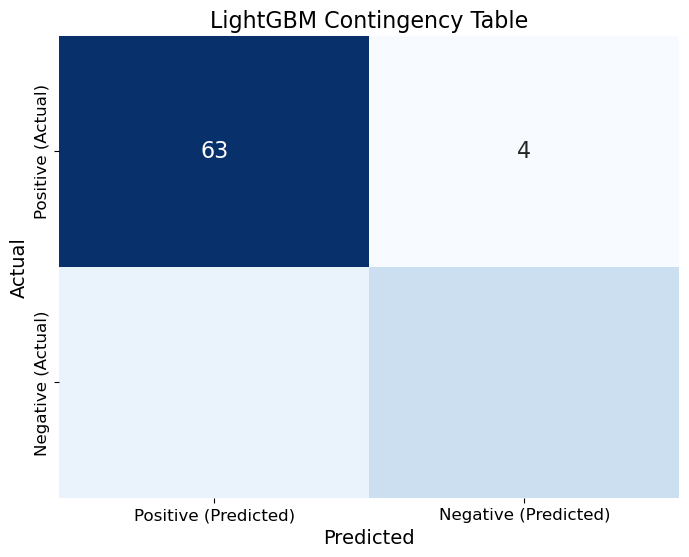


Features used in the model and their importance:
                                              Feature  Importance
1                                         Weight (kg)         145
0                                                 Age         138
5                                                 USG         109
4                          Duration of therapy (days)         102
7                                             Protein          80
30                              Bacteria quantity_3.0          75
10                                        Hemoprotein          73
11                                             Volume          66
13                                   WBC (simplified)          66
2                                Number of vet visits          64
12                                        Lipid Layer          59
6                                                  PH          57
25  Clarity (0 = clear; 1 = opaque/cloudy; 2 = SLh...          53
14                        

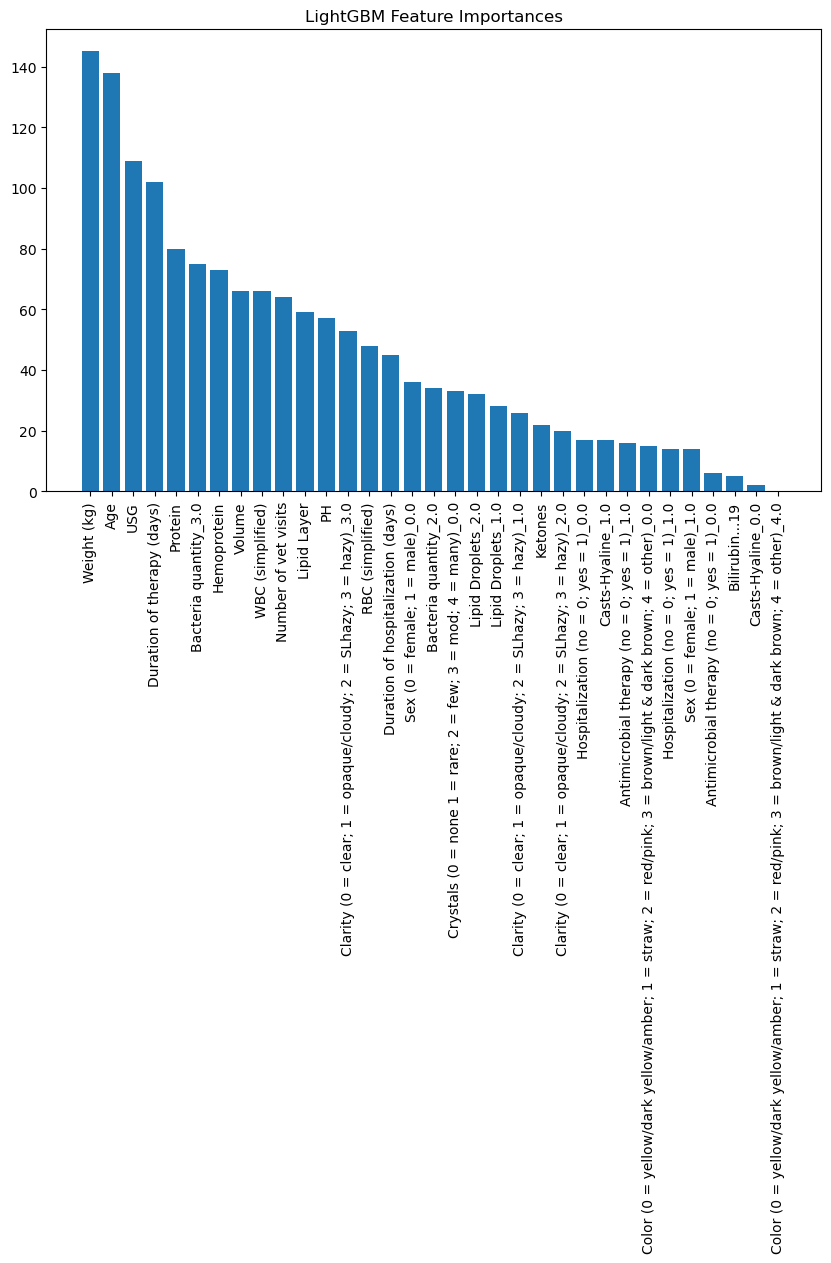

Training XGBoost...

XGBoost Performance:
Sensitivity: 0.9254, Specificity: 0.7200
Accuracy: 0.8696 (95% CI: [0.8007, 0.9384])

Contingency Table:
                   Positive (Predicted)  Negative (Predicted)
Positive (Actual)                    62                     5
Negative (Actual)                     7                    18


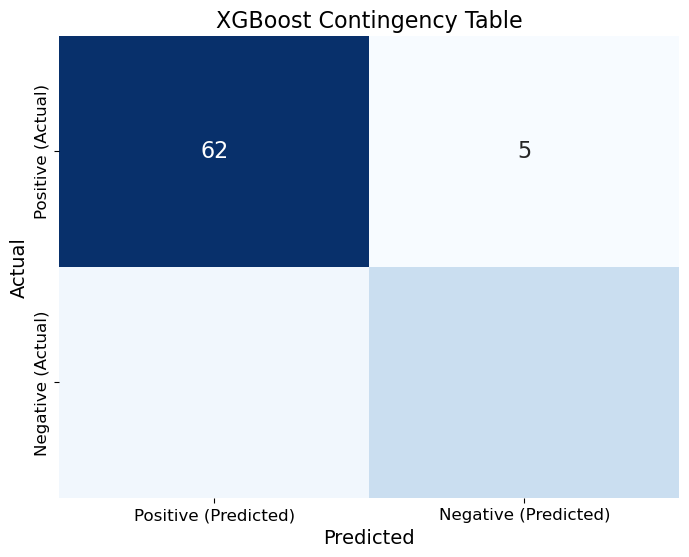


Features used in the model and their importance:
                                              Feature  Importance
25  Clarity (0 = clear; 1 = opaque/cloudy; 2 = SLh...    0.184927
19        Antimicrobial therapy (no = 0; yes = 1)_0.0    0.160098
8                                             Ketones    0.139223
29                              Bacteria quantity_2.0    0.056972
31                                 Lipid Droplets_1.0    0.052288
21  Color (0 = yellow/dark yellow/amber; 1 = straw...    0.044987
27                                  Casts-Hyaline_0.0    0.025694
15                     Sex (0 = female; 1 = male)_0.0    0.025591
1                                         Weight (kg)    0.023129
13                                   WBC (simplified)    0.021131
12                                        Lipid Layer    0.019936
28                                  Casts-Hyaline_1.0    0.019726
10                                        Hemoprotein    0.019139
6                         

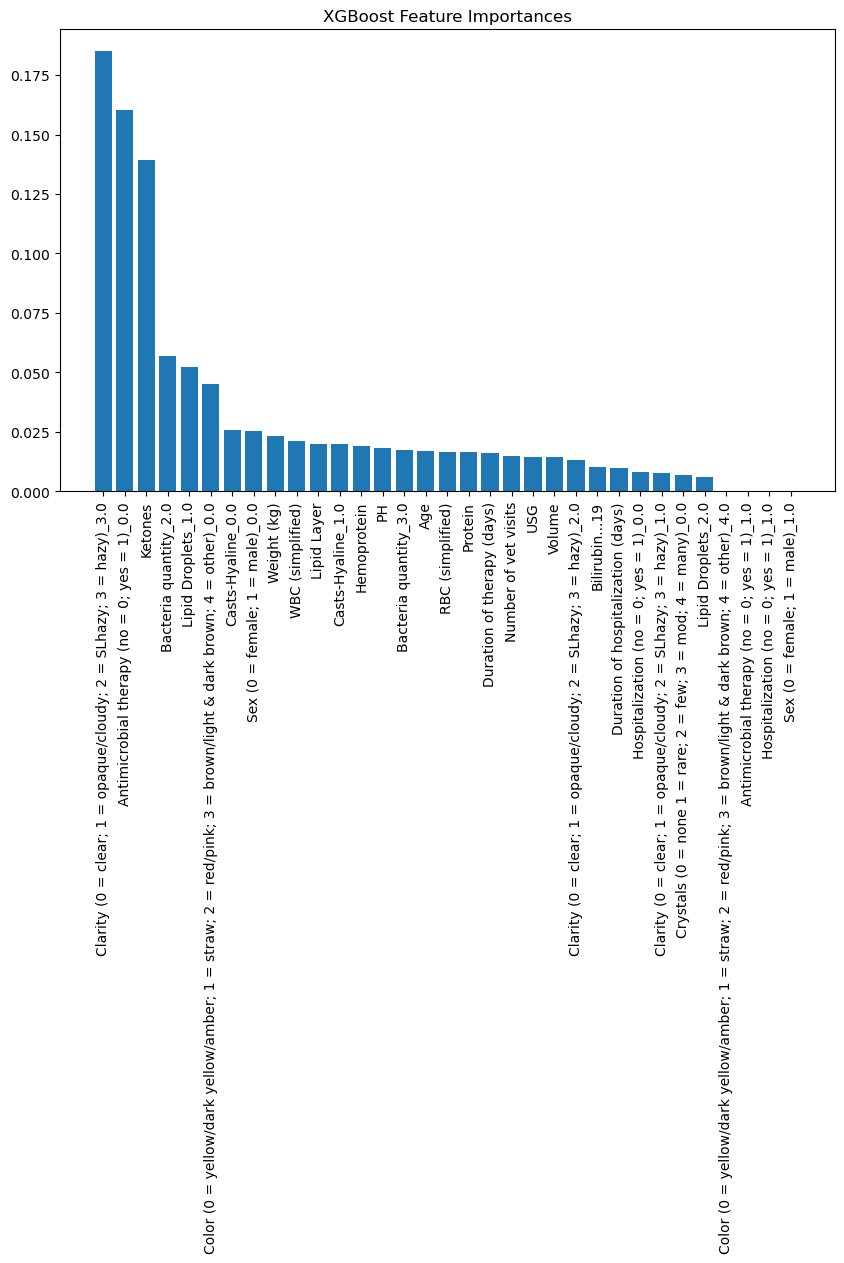

Training CatBoost...

CatBoost Performance:
Sensitivity: 0.9701, Specificity: 0.6800
Accuracy: 0.8913 (95% CI: [0.8277, 0.9549])

Contingency Table:
                   Positive (Predicted)  Negative (Predicted)
Positive (Actual)                    65                     2
Negative (Actual)                     8                    17


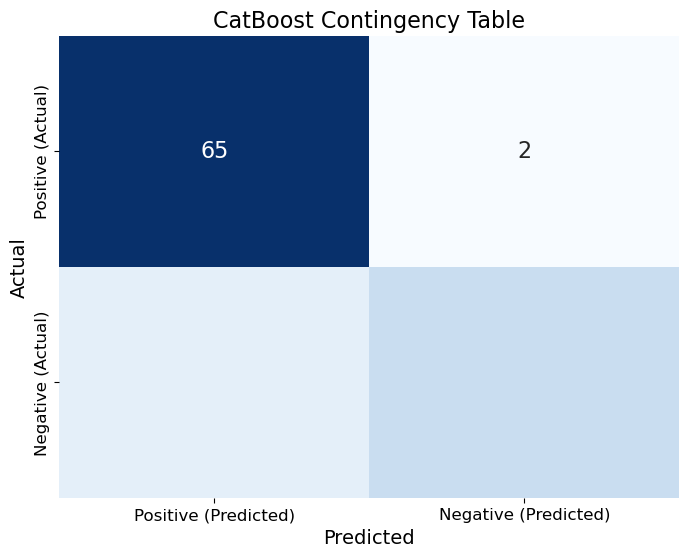


Features used in the model and their importance:
                                              Feature  Importance
25  Clarity (0 = clear; 1 = opaque/cloudy; 2 = SLh...    8.903245
19        Antimicrobial therapy (no = 0; yes = 1)_0.0    7.723729
20        Antimicrobial therapy (no = 0; yes = 1)_1.0    6.029160
30                              Bacteria quantity_3.0    5.749881
11                                             Volume    4.990835
12                                        Lipid Layer    4.736144
13                                   WBC (simplified)    4.447997
1                                         Weight (kg)    4.437956
4                          Duration of therapy (days)    4.021092
10                                        Hemoprotein    3.838275
2                                Number of vet visits    3.714665
6                                                  PH    3.552189
7                                             Protein    3.432279
0                         

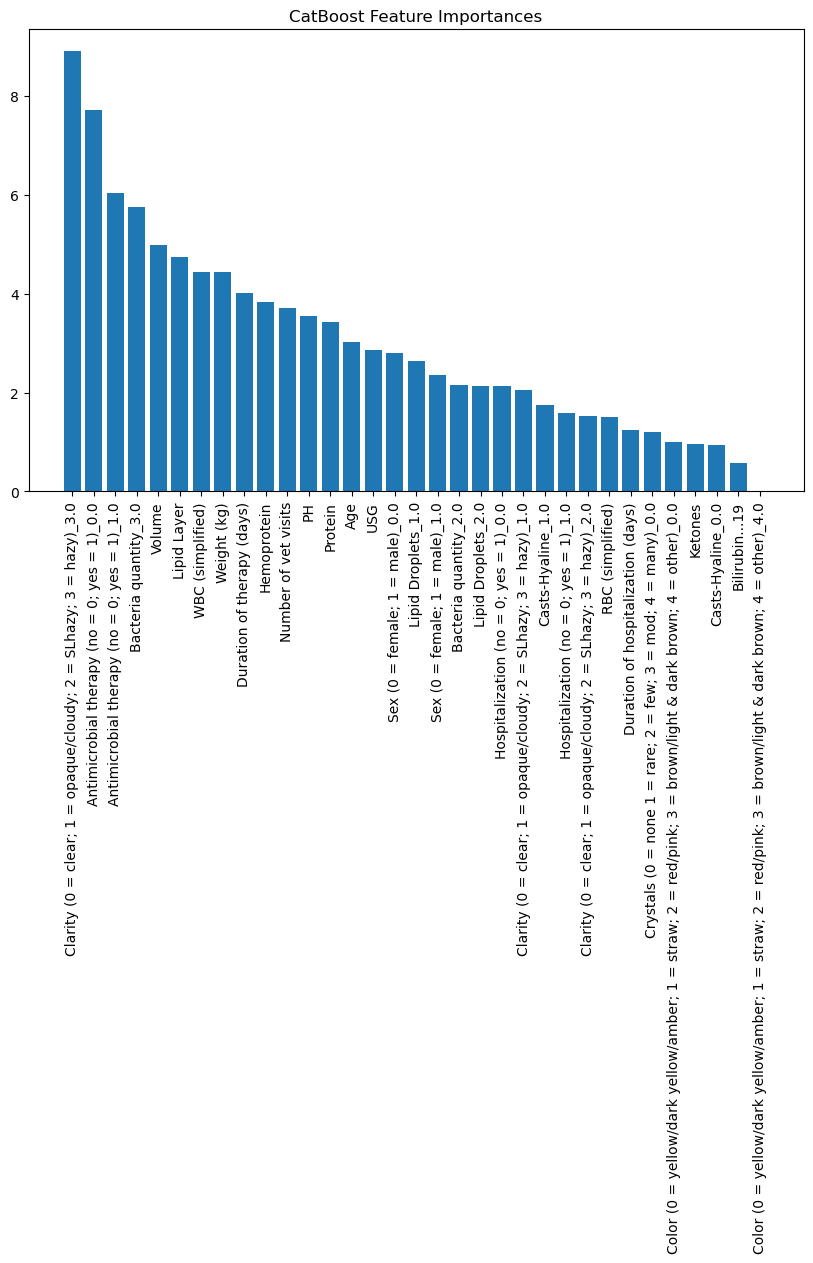

Training LogisticRegression...

LogisticRegression Performance:
Sensitivity: 0.9403, Specificity: 0.5600
Accuracy: 0.8370 (95% CI: [0.7615, 0.9124])

Contingency Table:
                   Positive (Predicted)  Negative (Predicted)
Positive (Actual)                    63                     4
Negative (Actual)                    11                    14


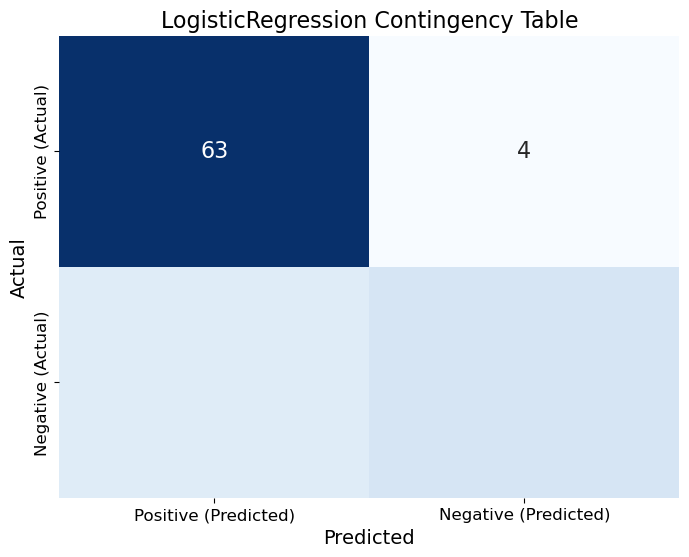


Features used in the model and their coefficients:
                                              Feature  Coefficient
25  Clarity (0 = clear; 1 = opaque/cloudy; 2 = SLh...     1.520429
26  Crystals (0 = none 1 = rare; 2 = few; 3 = mod;...     0.906974
4                          Duration of therapy (days)     0.904760
28                                  Casts-Hyaline_1.0     0.893765
20        Antimicrobial therapy (no = 0; yes = 1)_1.0     0.667618
12                                        Lipid Layer     0.568453
1                                         Weight (kg)     0.528165
8                                             Ketones     0.364298
23  Clarity (0 = clear; 1 = opaque/cloudy; 2 = SLh...     0.359289
7                                             Protein     0.221585
27                                  Casts-Hyaline_0.0     0.154104
18              Hospitalization (no = 0; yes = 1)_1.0     0.131789
0                                                 Age     0.131351
22  Color 

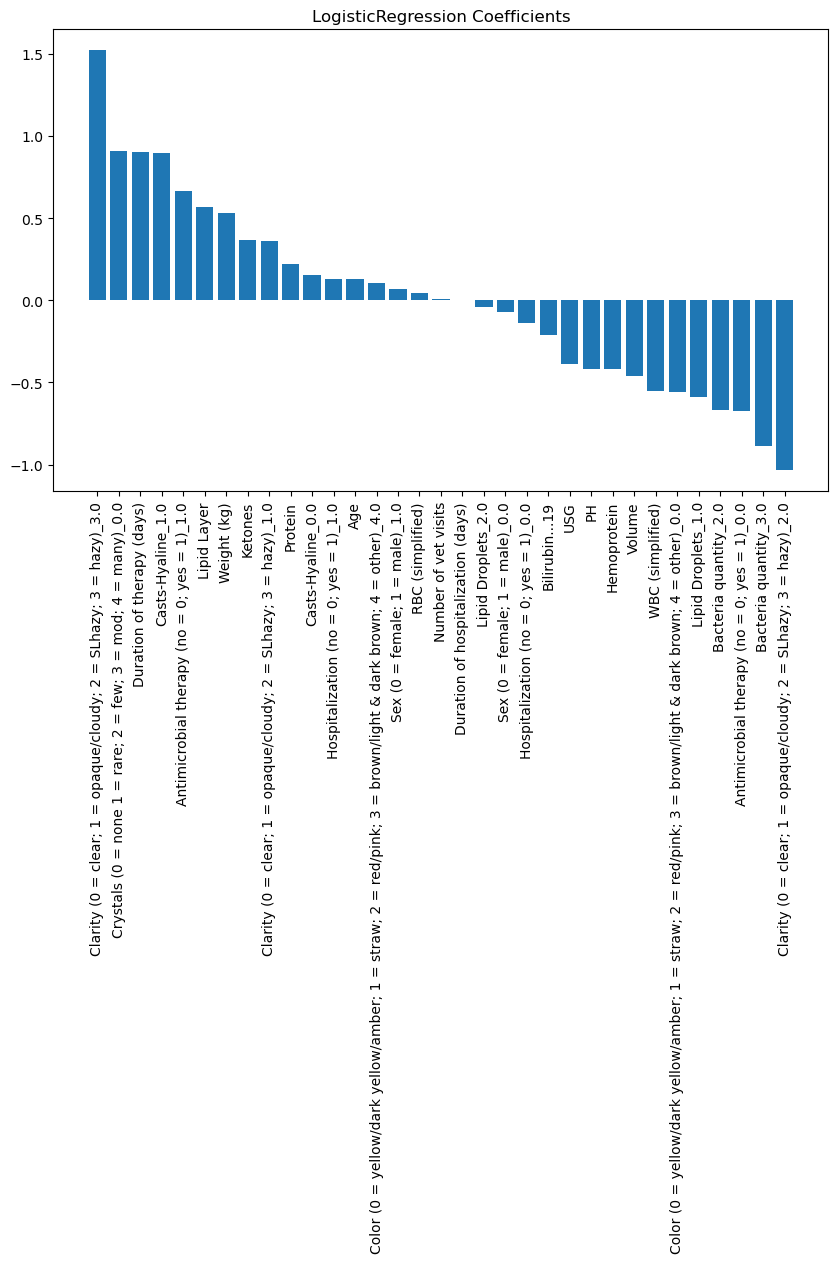

In [5]:
import seaborn as sns  # For heatmap visualization
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)  # Ensure the model is trained
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = accuracy_score(y_test, y_pred)
    n = len(y_test)
    p = accuracy
    z = 1.96  # 95% confidence interval
    ci_lower = max(0, p - z * np.sqrt((p * (1 - p)) / n))
    ci_upper = min(1, p + z * np.sqrt((p * (1 - p)) / n))
    
    print(f"\n{name} Performance:")
    print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
    print(f"Accuracy: {accuracy:.4f} (95% CI: [{ci_lower:.4f}, {ci_upper:.4f}])")
    
    # Contingency table (2x2 table)
    print("\nContingency Table:")
    contingency_table = pd.DataFrame(
        [[tp, fn], [fp, tn]],
        columns=["Positive (Predicted)", "Negative (Predicted)"],
        index=["Positive (Actual)", "Negative (Actual)"]
    )
    print(contingency_table)
    
    # Visualize the contingency table
    plt.figure(figsize=(8, 6))
    sns.heatmap(contingency_table, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
    plt.title(f"{name} Contingency Table", fontsize=16)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
    
    # Feature importances (or coefficients) depending on the model
    if hasattr(model, "feature_importances_"):
        # Tree-based models (RF, XGBoost, CatBoost, LightGBM)
        print("\nFeatures used in the model and their importance:")
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            "Feature": selected_feature_names,
            "Importance": importances
        }).sort_values(by="Importance", ascending=False)
        print(feature_importance_df)
        
        # Plot feature importances
        plt.figure(figsize=(10, 6))
        plt.title(f"{name} Feature Importances")
        plt.bar(range(len(importances)), feature_importance_df["Importance"], align="center")
        plt.xticks(range(len(importances)), feature_importance_df["Feature"], rotation=90)
        plt.tight_layout()
        plt.show()
    
    elif name == "LogisticRegression":
        # Logistic Regression model: extract coefficients
        print("\nFeatures used in the model and their coefficients:")
        importances = model.coef_[0]  # For binary classification, shape is (1, n_features)
        feature_importance_df = pd.DataFrame({
            "Feature": selected_feature_names,
            "Coefficient": importances
        }).sort_values(by="Coefficient", ascending=False)
        print(feature_importance_df)
        
        # Plot coefficients
        plt.figure(figsize=(10, 6))
        plt.title(f"{name} Coefficients")
        plt.bar(range(len(importances)), feature_importance_df["Coefficient"], align="center")
        plt.xticks(range(len(importances)), feature_importance_df["Feature"], rotation=90)
        plt.tight_layout()
        plt.show()